# Rapport: Förutsägelse av hjärt- och kärlsjukdomar med maskininlärning

## Introduktion och problemställning
Denna rapport syftar till att undersöka och analysera klinisk och demografisk data för att utveckla en prediktiv modell som kan förutsäga hjärt- och kärlsjukdomar. Genom att använda avancerade maskininlärningstekniker på ett öppet dataset från [Kaggle](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset), strävar denna studie efter att identifiera signifikanta riskfaktorer för dessa sjukdomar. I denna studie hanterades datamängden som innehåller betydande mängder felaktigheter, inklusive negativa blodtrycksvärden och andra omöjliga fysiologiska mätvärden, noggrant under dataförberedelsen. Efter en granskning av datakällan kan datat även antas vara helt fabricerat med anledningar som inkludera brister i dokumentationen kring glukos och kolestrol, oklart ursprung och misstänkta datapunkter som verkar inkonsekventa eller onormala.

Denna rapport är framställd som en del av en akademisk kurs och innehåller omfattande analyser, inklusive datarensning, modellering, hyperparameteroptimering och slutligen paketering av modellen för demonstration. Resultaten är avsedda att bidra till medicinsk forskning och praktik genom att ge insikter som kan förbättra tidig diagnos och behandling av hjärt-kärlsjukdomar.

## Metoder
### Dataförbehandling
Projektet inleddes med en initial dataset bestående av 70 000 poster från Kaggle. Efter att ha identifierat och eliminerat orimliga värden som negativa blodtryck och extrema kroppsmått, reducerades datasetet till 65,199 observationer. En betydande del av dataförberedelsen var att skapa en ny feature för att beräkna kroppsmasseindex (BMI) från vikt och längd.

### Datafiltrering
Datat filtrerades genom att definiera medicinskt och biometriskt rimliga intervall för varje variabel:
- **Blodtryck:** Kategorier definerades enligt [Blodtrycksdoktorn's](https://my.clevelandclinic.org/health/body/21629-pulse-pressure) Systoliskt blodtryck begränsades till 80-180 mm Hg och diastoliskt blodtryck till 50-120 mm Hg efter konsultation med läkare.
- **Vikt och Längd:** Viktintervallet sattes till 50-140 kg och längdintervallet till 147-220 cm baserat på ovetskap kring demografin.
- **Ålder:** Endast individer 39 år och äldre inkluderades eftersom individer under 39 var extremt få.
- **BMI:** Accepterade värden mellan 15 och 40 för att exkludera extrem under- och övervikt. Kategorier definerades enligt [WHO's](https://www.kry.se/fakta/bmi) riktlinjer.

### Utforskande dataanalys (EDA)
EDA-segmentet gav insikter i förekomsten av hjärt-kärlsjukdomar och relaterade faktorer. Viktiga observationer från analysen inkluderar fördelningen av kolesterolnivåer, ålder, rökvanor samt vikt- och längdfördelningar. Särskild uppmärksamhet gavs åt korrelation mellan dessa faktorer och prevalensen av hjärt-kärlsjukdomar bland olika demografiska grupper.


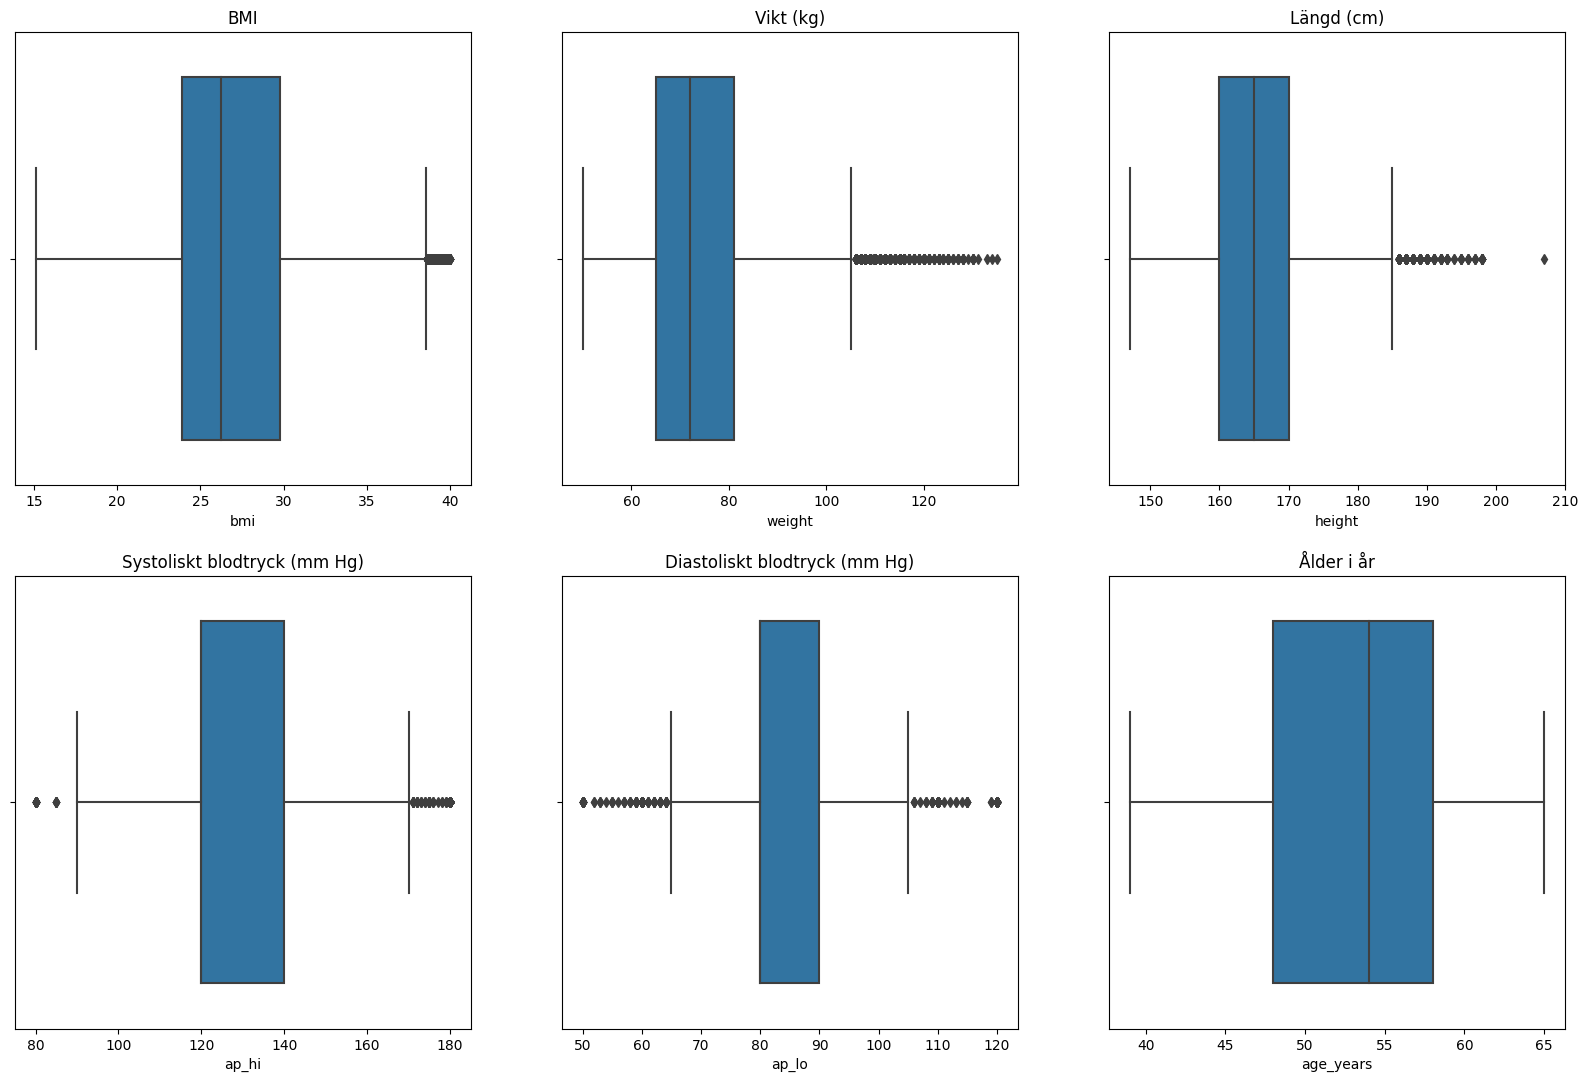

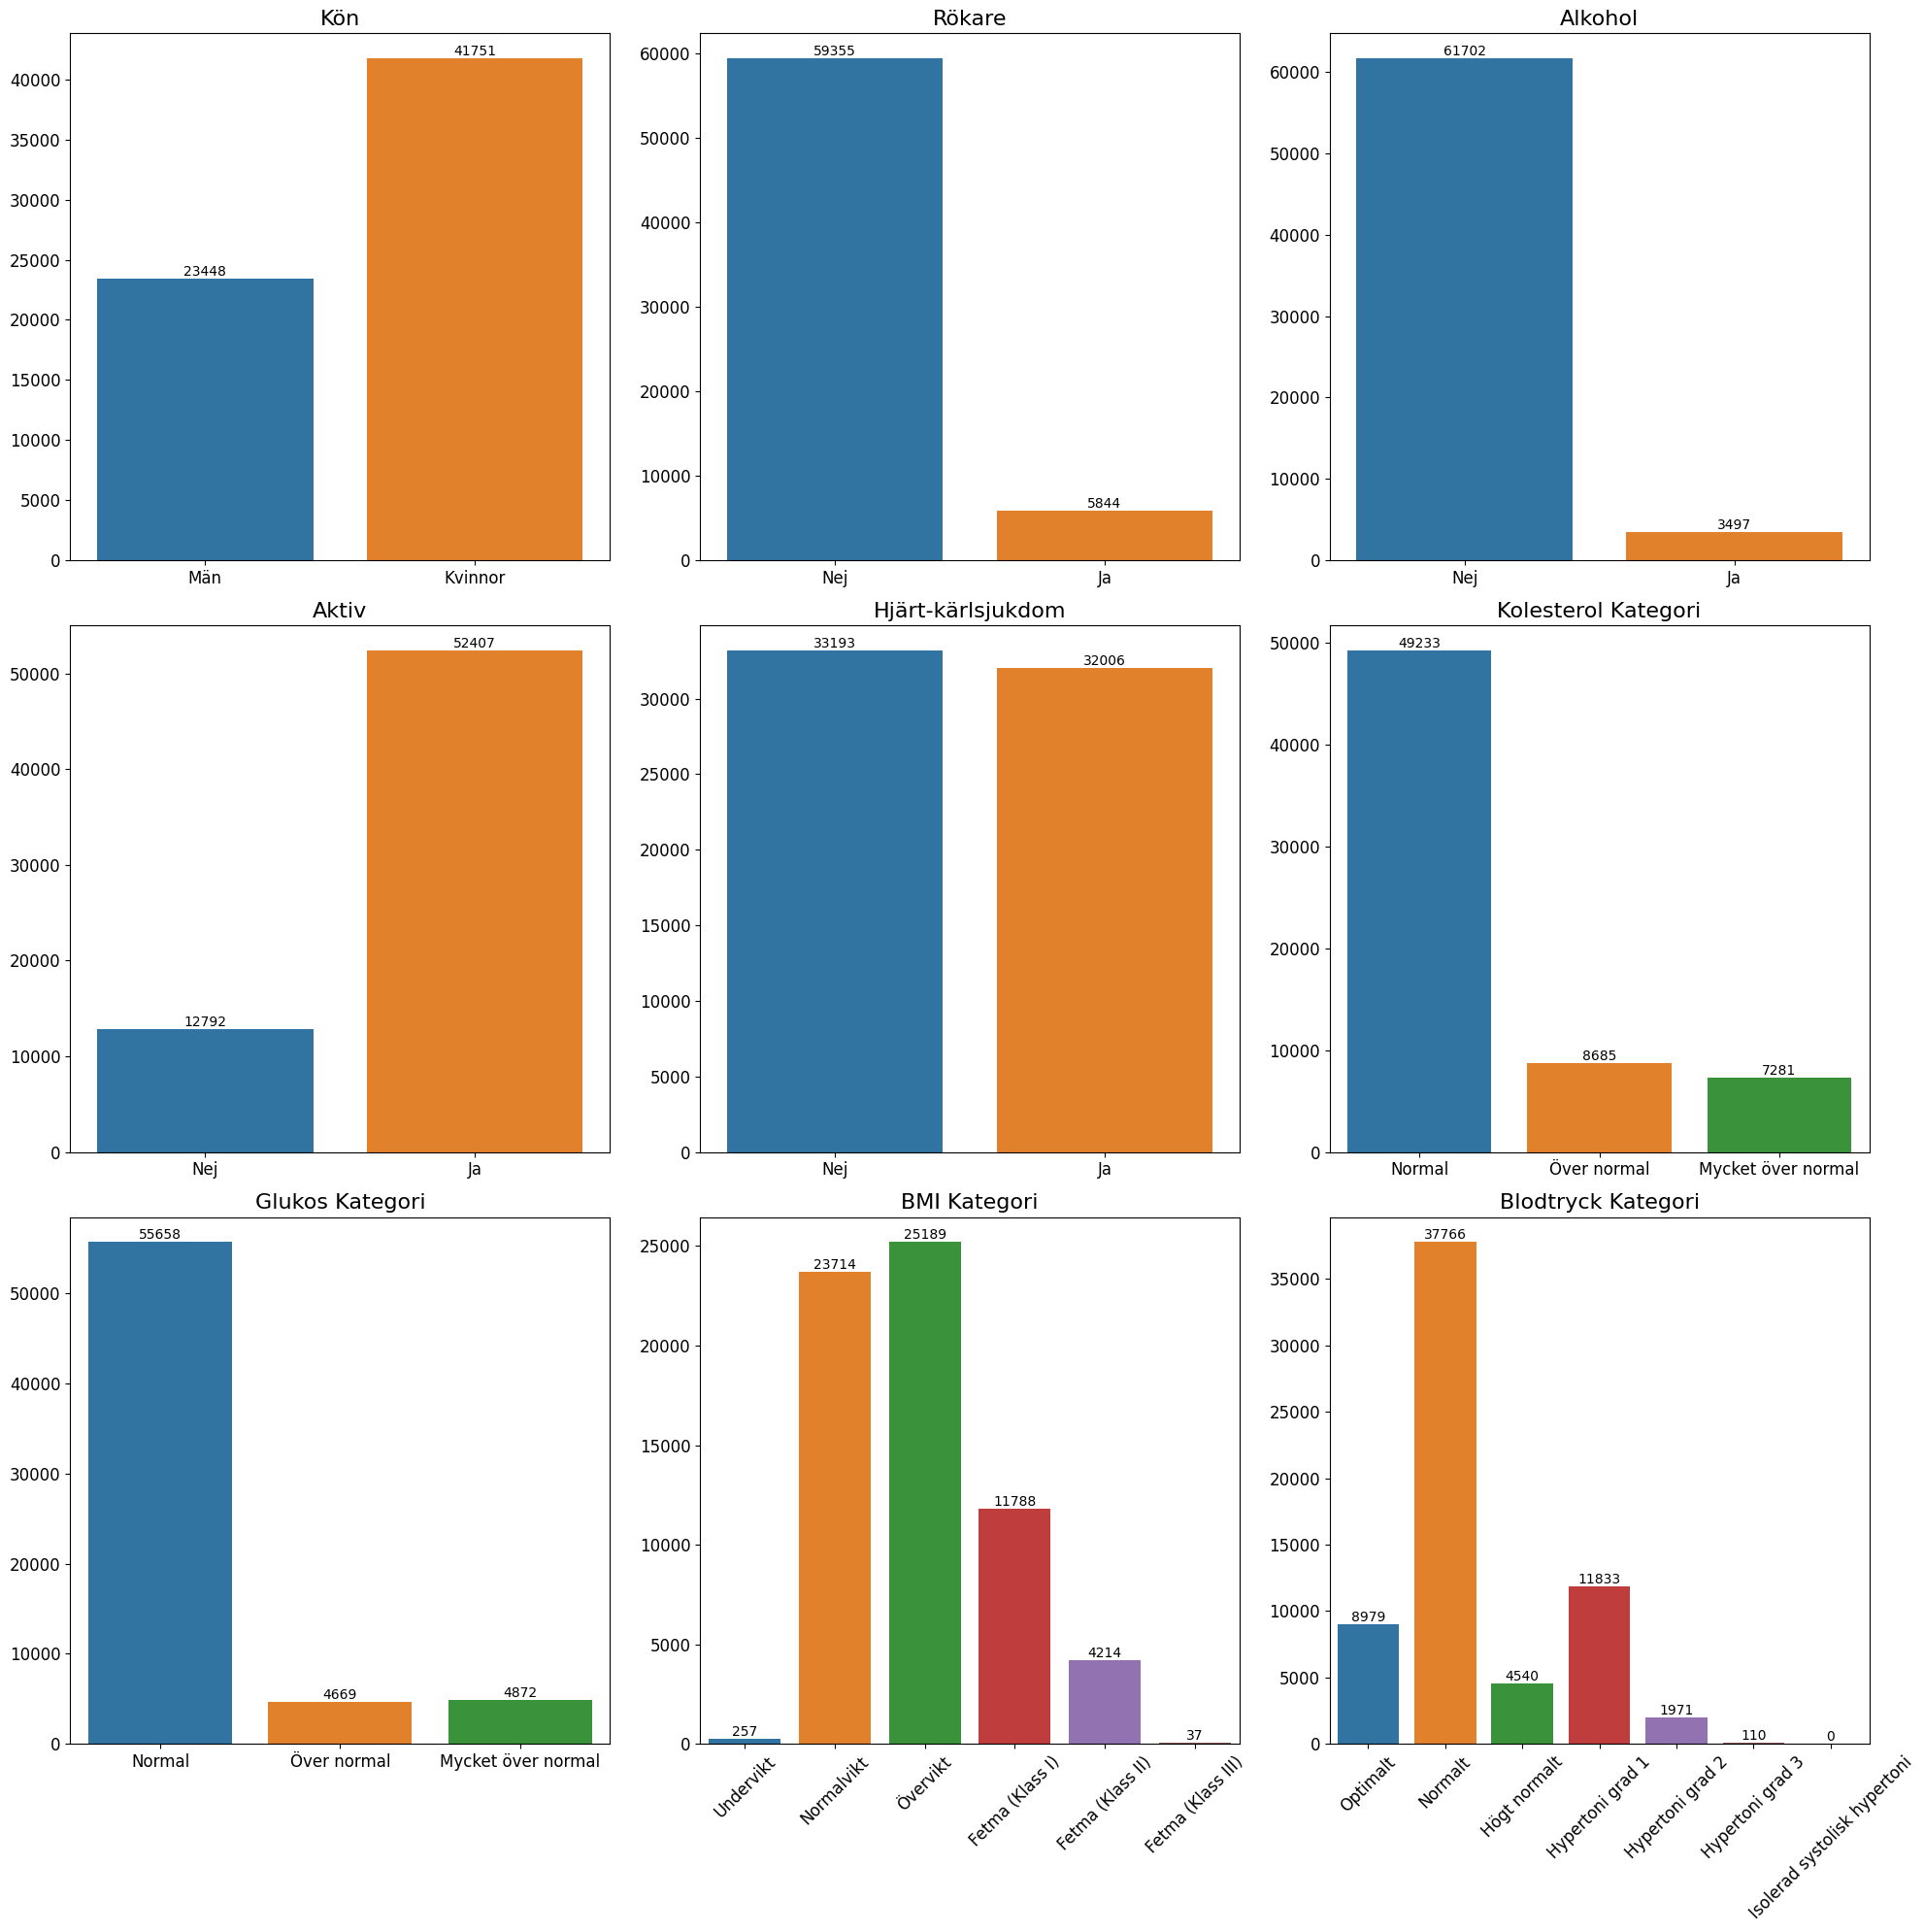

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Läser in data
data = pd.read_csv('data/cardio_train.csv', sep=";")

# Omvandlar ålder och avrundar till närmaste heltal, beräknar BMI
data['age_years'] = (data['age'] / 365.25).round()
data['bmi'] = data['weight'] / (data['height'] / 100) ** 2

# Initial datafiltrering för att avlägsna orimliga värden
filtered_data = data[
    (data['height'] <= 220) &  # Gränsvärden för längd: 147 cm till 220 cm
    (data['height'] >= 147) & 
    (data['ap_hi'] <= 180) &   # Gränsvärden för systoliskt blodtryck: 80 mm Hg till 180 mm Hg
    (data['ap_hi'] >= 80) &
    (data['ap_lo'] <= 120) &   # Gränsvärden för diastoliskt blodtryck: 50 mm Hg till 120 mm Hg
    (data['ap_lo'] >= 50) &
    (data['ap_lo'] < data['ap_hi']) &  # Säkerställer att diastoliskt blodtryck är lägre än systoliskt
    (data['weight'] >= 50) &   # Gränsvärden för vikt: 50 kg till 140 kg
    (data['weight'] <= 140) &
    (data['bmi'] >= 15) &      # Gränsvärden för BMI: 15 till 40
    (data['bmi'] <= 40) &
    (data['age_years'] >= 39)  # Inkluderar endast individer som är 39 år eller äldre
].copy() # Kopia av det filtrerade datasetet för att undvika att ändra originaldata


# EDA-frågor
eda_results = {
    'positiva_för_sjukdom': filtered_data['cardio'].sum(),
    'negativa_för_sjukdom': len(filtered_data) - filtered_data['cardio'].sum(),
    'cholesterol_fördelning': filtered_data['cholesterol'].value_counts(normalize=True) * 100,
    'åldersfördelning': filtered_data['age_years'].describe(),
    'röker_andel': filtered_data['smoke'].mean() * 100,
    'viktfördelning': filtered_data['weight'].describe(),
    'längdfördelning': filtered_data['height'].describe(),
    'sjukdom_kön_fördelning': filtered_data.groupby('gender')['cardio'].mean() * 100}

# Tar bort onödiga kolumner
filtered_data.drop(columns=['age', 'id'], inplace=True)

# Funktioner för att kategorisera BMI och blodtryck baserat på medicinska riktlinjer
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Undervikt'
    elif bmi <= 24.9:
        return 'Normalvikt'
    elif bmi <= 29.9:
        return 'Övervikt'
    elif bmi <= 34.9:
        return 'Fetma (Klass I)'
    elif bmi <= 39.9:
        return 'Fetma (Klass II)'
    else:
        return 'Fetma (Klass III)'

def categorize_blood_pressure(ap_hi, ap_lo):
    if ap_hi < 120 and ap_lo < 80:
        return 'Optimalt'
    elif 120 <= ap_hi <= 129 or 80 <= ap_lo <= 84:
        return 'Normalt'
    elif 130 <= ap_hi <= 139 or 85 <= ap_lo <= 89:
        return 'Högt normalt'
    elif 140 <= ap_hi <= 159 or 90 <= ap_lo <= 99:
        return 'Hypertoni grad 1'
    elif 160 <= ap_hi <= 179 or 100 <= ap_lo <= 109:
        return 'Hypertoni grad 2'
    elif ap_hi >= 180 or ap_lo >= 110:
        return 'Hypertoni grad 3'
    elif ap_hi >= 140 and ap_lo < 90:
        return 'Isolerad systolisk hypertoni'
    else:
        return 'Okategoriserat'

def categorize_cholesterol(chol):
    if chol == 1:
        return 'Normal'
    elif chol == 2:
        return 'Över normal'
    elif chol == 3:
        return 'Mycket över normal'

def categorize_glucose(gluc):
    if gluc == 1:
        return 'Normal'
    elif gluc == 2:
        return 'Över normal'
    elif gluc == 3:
        return 'Mycket över normal'

# Skapar kategoriska kolumner
filtered_data['BMI_category'] = filtered_data['bmi'].apply(categorize_bmi)
filtered_data['Blood_pressure_category'] = filtered_data.apply(
    lambda row: categorize_blood_pressure(row['ap_hi'], row['ap_lo']), axis=1)
filtered_data['Cholesterol_category'] = filtered_data['cholesterol'].apply(categorize_cholesterol)
filtered_data['Glucose_category'] = filtered_data['gluc'].apply(categorize_glucose)

# Mappar för svenska namn och enheter
column_names_map = {
    'weight': 'Vikt (kg)',
    'height': 'Längd (cm)',
    'ap_hi': 'Systoliskt blodtryck (mm Hg)',
    'ap_lo': 'Diastoliskt blodtryck (mm Hg)',
    'age_years': 'Ålder i år',
    'cholesterol': 'Kolesterol',
    'gluc': 'Glukos',
    'gender': 'Kön',
    'smoke': 'Rökare',
    'alco': 'Alkohol',
    'active': 'Aktiv',
    'cardio': 'Hjärt-kärlsjukdom',
    'bmi': 'BMI',
    'BMI_category': 'BMI Kategori',
    'Blood_pressure_category': 'Blodtryck Kategori',
    'Cholesterol_category': 'Kolesterol Kategori',
    'Glucose_category': 'Glukos Kategori'
}

# Förbereder kolumnlistor för olika plot-typer
boxplot_columns = ['bmi', 'weight', 'height', 'ap_hi', 'ap_lo', 'age_years']  # Kontinuerliga variabler
barplot_columns = ['gender', 'smoke', 'alco', 'active', 'cardio', 'Cholesterol_category', 'Glucose_category', 'BMI_category', 'Blood_pressure_category' ]  # Kategoriska variabler

# Anger figurstorlek för boxplots
plt.figure(figsize=(20, 20))

# Loopar för boxplots
for i, col in enumerate(boxplot_columns, 1):
    plt.subplot(3, 3, i)  # Justera positionen efter subplot layout
    sns.boxplot(x=filtered_data[col])
    plt.title(column_names_map[col])

# Anger figurstorlek för barplots
plt.figure(figsize=(20, 20))

# Definierar ordningen för BMI, blodtryck, kolesterol och glukos kategorier
bmi_order = ['Undervikt', 'Normalvikt', 'Övervikt', 'Fetma (Klass I)', 'Fetma (Klass II)', 'Fetma (Klass III)']
blood_pressure_order = ['Optimalt', 'Normalt', 'Högt normalt', 'Hypertoni grad 1', 'Hypertoni grad 2', 'Hypertoni grad 3', 'Isolerad systolisk hypertoni']
cholesterol_order = ['Normal', 'Över normal', 'Mycket över normal']
glucose_order = ['Normal', 'Över normal', 'Mycket över normal']

# Använder den specifika ordern till barplots
for i, col in enumerate(barplot_columns, 1):
    ax = plt.subplot(3, 3, i)
    rotate_labels = False
    if col == 'BMI_category':
        sns.countplot(x=filtered_data[col], order=bmi_order, ax=ax)
        rotate_labels = True
    elif col == 'Blood_pressure_category':
        sns.countplot(x=filtered_data[col], order=blood_pressure_order, ax=ax)
        rotate_labels = True
    elif col == 'Cholesterol_category':
        sns.countplot(x=filtered_data[col], order=cholesterol_order, ax=ax)
        rotate_labels = False
    elif col == 'Glucose_category':
        sns.countplot(x=filtered_data[col], order=glucose_order, ax=ax)
        rotate_labels = False
    elif col == 'gender':
        sns.countplot(x=filtered_data[col].map({1: 'Kvinnor', 2: 'Män'}), ax=ax)
    elif col in ['smoke', 'alco', 'active', 'cardio']:
        order = ['Nej', 'Ja']
        sns.countplot(x=filtered_data[col].map({0: 'Nej', 1: 'Ja'}), order=order, ax=ax)
    plt.title(column_names_map[col], fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for container in ax.containers:
        ax.bar_label(container, fontsize=10)
    ax.tick_params(labelsize=12)
    if rotate_labels:
        plt.xticks(rotation=45)  # Endast rotation för BMI, blodtryck

plt.tight_layout()
plt.show()

## Normalisering och Feature Engineering

För att förbättra modellernas prestanda och säkerställa en rättvis jämförelse mellan variabler, utfördes en normalisering av både kontinuerliga och kategoriska variabler. Dessutom infördes nya kombinerade features för att utforska ytterligare samband i datan.

### Normalisering

Normaliseringen syftar till att omforma datavärdena till en gemensam skala utan att förvränga skillnader i värdenas intervall eller förlora information. För kontinuerliga variabler såsom längd, vikt, blodtryck, BMI och ålder, justerades varje värde relativt det minsta och största värdet enligt formeln:

$$ \text{normalized\_value} = \frac{\text{value} - \text{min\_value}}{\text{max\_value} - \text{min\_value}} $$

För kategoriska variabler som kolesterol och glukos, justerades dessa genom en enkel proportionalitetsberäkning för att de ska kunna jämföras på lika villkor.

### Ytterligare Feature Engineering

Vi inför även nya features baserade på befintliga data för att ge ytterligare insikter:

- **Pulstryck:** Beräknas som skillnaden mellan systoliskt och diastoliskt blodtryck och är en viktig indikator på hjärt-kärlhälsa.
**Källa:** https://my.clevelandclinic.org/health/body/21629-pulse-pressure
- **Metabolisk stress:** Ett mått som kombinerar normaliserade värden av glukos och kolesterol, vilket kan indikera högre risknivåer för hjärt-kärlsjukdomar.
- **Rökning och Alkohol:** En sammanslagen feature som väger samman individens rök- och alkoholvanor för att undersöka sambandet mellan livsstil och hjärt-kärlhälsa.

Dessa features inkluderades i korrelationsanalysen för att identifiera vilka faktorer som är mest förutsägbara för hjärt-kärlsjukdomar.

### Korrelationsanalys

Korrelationsanalys utfördes för att identifiera sambanden mellan variabler och hjärt-kärlsjukdom, vilket illustreras i korrelationsmatrisen.

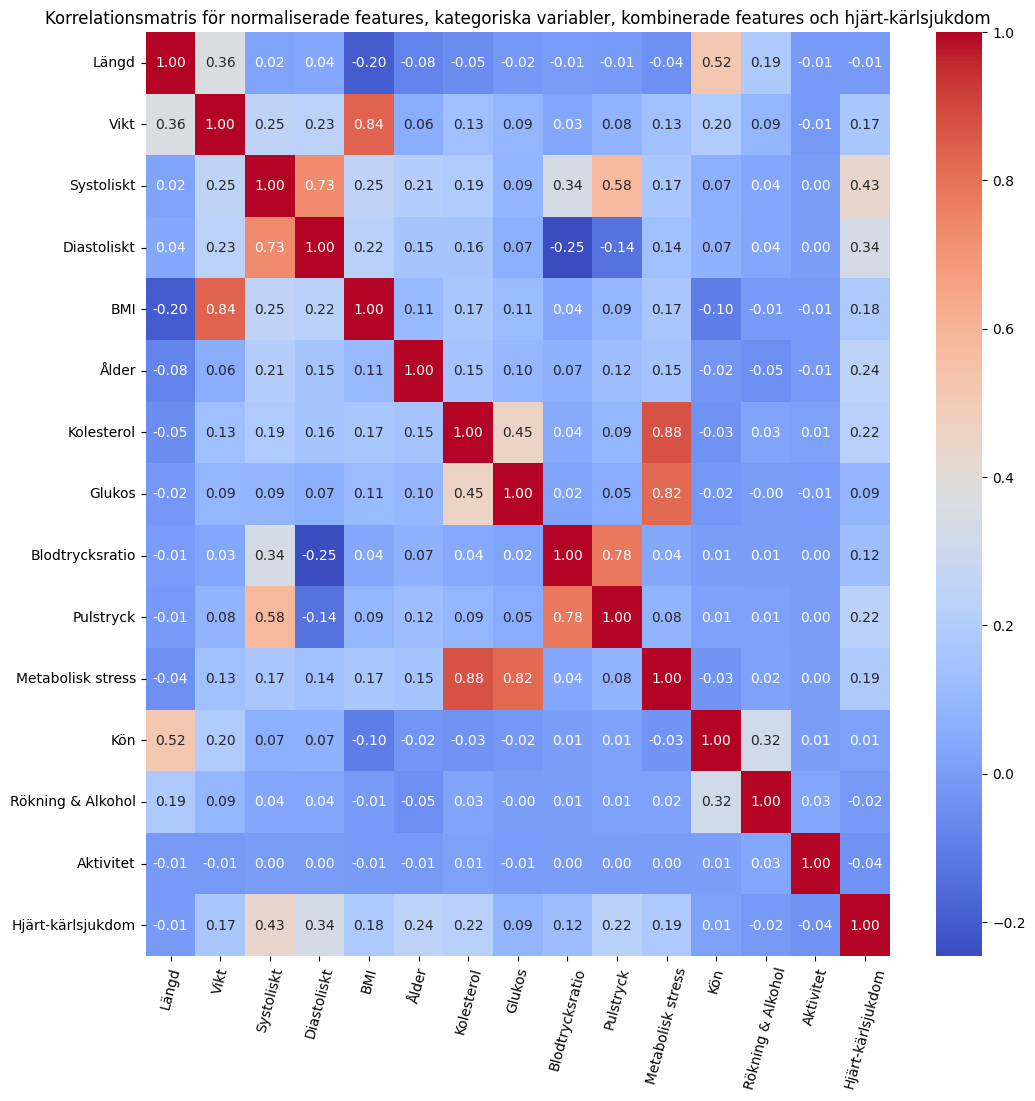

In [2]:
# Normalisering av kontinuerliga variabler
normalized_columns = ['height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'age_years']
for col in normalized_columns:
    min_col = filtered_data[col].min()
    max_col = filtered_data[col].max()
    filtered_data['norm_' + col] = (filtered_data[col] - min_col) / (max_col - min_col)

# Normalisering av kategoriska variabler (kolesterol och glukos)
filtered_data['norm_cholesterol'] = filtered_data['cholesterol'] / 3.0
filtered_data['norm_gluc'] = filtered_data['gluc'] / 3.0

# Beräknar och normaliserar ytterligare features
filtered_data['norm_bp_ratio'] = filtered_data['norm_ap_hi'] / filtered_data['norm_ap_lo']
filtered_data['norm_pulse_pressure'] = (filtered_data['norm_ap_hi'] - filtered_data['norm_ap_lo'] - filtered_data['norm_ap_hi'].min() + filtered_data['norm_ap_lo'].min()) / (filtered_data['norm_ap_hi'].max() - filtered_data['norm_ap_lo'].min() - filtered_data['norm_ap_hi'].min() + filtered_data['norm_ap_lo'].max())

# Omvandlar kategoriska variabler till numeriska
filtered_data['gender'] = filtered_data['gender'].map({1: 0, 2: 1})
filtered_data['smoke'] = filtered_data['smoke'].map({0: 0, 1: 1})
filtered_data['alco'] = filtered_data['alco'].map({0: 0, 1: 1})
filtered_data['active'] = filtered_data['active'].map({0: 0, 1: 1})

# Skapar kombinerade features för smoke och alco (viktade) samt glukos och kolesterol
filtered_data['smoke_alco'] = filtered_data['smoke'] + filtered_data['alco']
# Justerar så att den kombinerade featuren har värdena 1, 0.5 och 0
filtered_data['smoke_alco'] = filtered_data['smoke_alco'].apply(lambda x: 1 if x == 2 else (0.5 if x == 1 else 0))
filtered_data['norm_metabolic_stress'] = (filtered_data['norm_gluc'] + filtered_data['norm_cholesterol']) / 2

# Lägger till den kombinerade featuren i kolumnlistan för korrelationsanalysen
columns_to_keep = [col for col in filtered_data.columns if 'norm_' in col] + ['gender', 'smoke_alco', 'active', 'cardio']
filtered_data_corr = filtered_data[columns_to_keep]

# Lägger till de nya normaliserade namnen i column_names_map
column_names_map.update({
    'norm_height': 'Längd',
    'norm_weight': 'Vikt',
    'norm_ap_hi': 'Systoliskt',
    'norm_ap_lo': 'Diastoliskt',
    'norm_bmi': 'BMI',
    'norm_age_years': 'Ålder',
    'norm_cholesterol': 'Kolesterol',
    'norm_gluc': 'Glukos',
    'norm_bp_ratio': 'Blodtrycksratio',
    'norm_pulse_pressure': 'Pulstryck',
    'norm_metabolic_stress': 'Metabolisk stress',
    'gender': 'Kön',
    'smoke_alco': 'Rökning & Alkohol',
    'active': 'Aktivitet',
    'cardio': 'Hjärt-kärlsjukdom'
})

# Byter namn på kolumnerna för visualisering
filtered_data_corr.rename(columns=column_names_map, inplace=True)

# Beräknar korrelationsmatrisen igen med den nya kombinerade featuren
correlation_matrix = filtered_data_corr.corr()

# Visar korrelationsmatrisen
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Korrelationsmatris för normaliserade features, kategoriska variabler, kombinerade features och hjärt-kärlsjukdom')
plt.xticks(rotation=75)
plt.show()

### Avancerad Dataanalys och Modellering
I detta avsnitt presenteras de avancerade dataanalysmetoderna och modelleringsteknikerna som användes för att utforska och förutsäga förekomsten av hjärt-kärlsjukdomar. Projektet inleddes med att konvertera kategoriska attribut till numeriska koder för att förenkla beräkningar och maskininlärningsprocesser. Därefter implementerades en huvudkomponentanalys (PCA) för att minska dimensionerna i vårt dataset och isolera de mest informativa egenskaperna.

En logistisk regressionsanalys utfördes för att bestämma sambanden mellan olika prediktorer och sjukdomsförekomst. Under analysen kontrollerades multicollinearity genom att beräkna Variance Inflation Factor (VIF) för de inkluderade variablerna. Modellens förmåga att korrekt klassificera fall av hjärt-kärlsjukdom utvärderades genom att konstruera och analysera en Receiver Operating Characteristic (ROC) kurva samt dess Area Under Curve (AUC).

### Modellträning och prestandautvärdering
Efter förberedelse och förbehandling av data, fokuserades på träningsprocessen för flera maskininlärningsmodeller samt utvärdering av deras prestanda på testdata. Flera klassificeringsalgoritmer, inklusive Logistisk Regression, Beslutsträd, Random Forest, Gradient Boosting och Support Vector Machines (SVM), evaluerades. För varje modell användes hyperparameteroptimering via Grid Search och Randomized Search för att finjustera inställningarna och maximera modellens noggrannhet. Modellernas effektivitet utvärderades genom att beräkna noggrannhetsskårer och andra relevanta mått som AUC och förvirringsmatriser på testdatat.

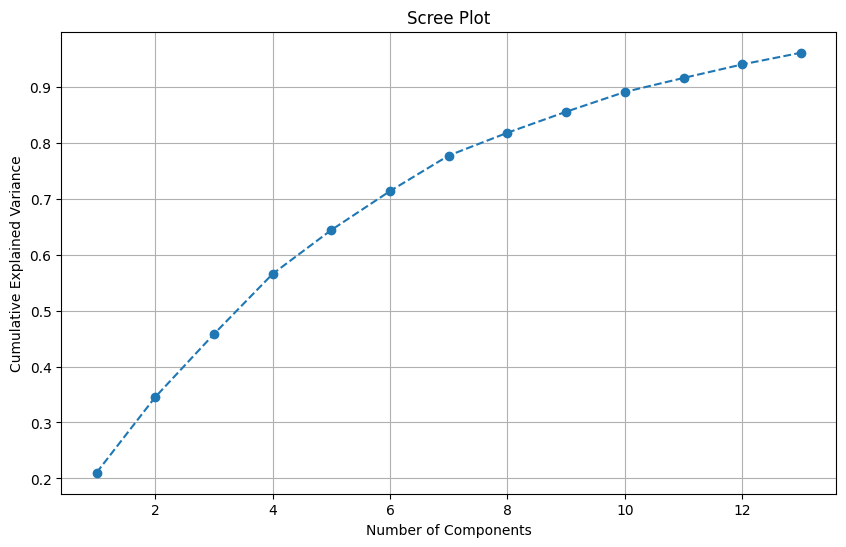

VIF data:
       feature           VIF
0        const  1.000000e+00
1          PC1  7.937947e+04
2          PC2  9.268571e+05
3          PC3  4.565756e+06
4          PC4  2.160181e+06
5          PC5  1.535054e+05
6          PC6  5.786500e+06
7          PC7  6.989529e+04
8          PC8  2.921387e+04
9          PC9  5.389611e+04
10        PC10  2.475902e+05
11        PC11  7.392571e+03
12        PC12  1.808489e+04
13        PC13  4.065286e+00
14      gender  2.626071e+05
15  smoke_alco  1.220997e+07
16      active  3.717837e+05
Optimization terminated successfully.
         Current function value: 0.558166
         Iterations 8
Regression results:
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                65154
Model:                          Logit   Df Residuals:                    65137
Method:                           MLE   Df Model:                           16
Date:                Wed, 19 J

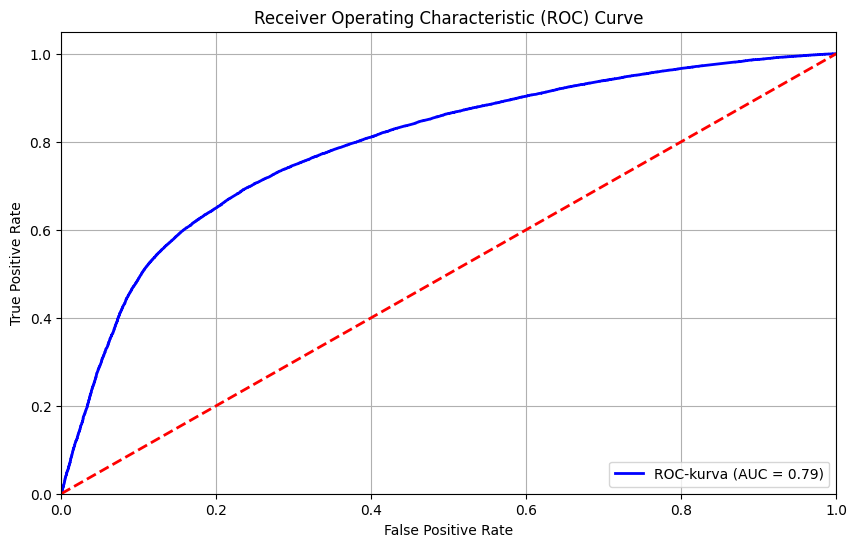

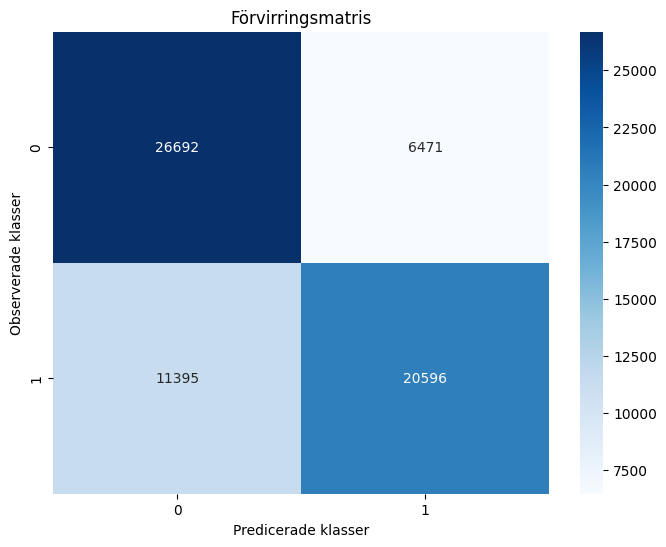

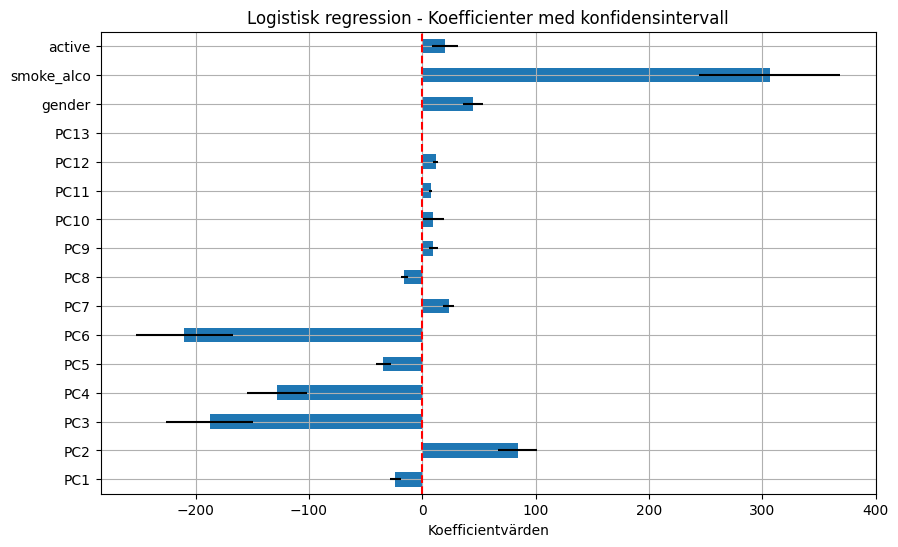

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Omvandlar kategoriska variabler till numeriska
category_columns = ['BMI_category', 'Blood_pressure_category', 'Cholesterol_category', 'Glucose_category']
for col in category_columns:
    filtered_data[col] = filtered_data[col].astype('category').cat.codes

# PCA
def perform_pca(data, variance_threshold=0.95):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    pca = PCA(n_components=variance_threshold)
    principal_components = pca.fit_transform(scaled_data)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    return principal_components, cumulative_variance

# Utför PCA
X = filtered_data.drop(columns=['cardio'])
y = filtered_data['cardio']

# Ersätter oändliga värden med NaN och ta bort rader med NaN-värden
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

principal_components, cumulative_variance = perform_pca(X)

# Plottar Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Lägger till de huvudsakliga komponenterna i en DataFrame
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Lägger till beroende variabel (cardio) och kategoriska variabler
principal_df['cardio'] = y.loc[X.index].values
principal_df['gender'] = filtered_data['gender'].loc[X.index].values
principal_df['smoke_alco'] = filtered_data['smoke_alco'].loc[X.index].values
principal_df['active'] = filtered_data['active'].loc[X.index].values

# Regressionsanalys
def regression_analysis(data):
    # Välj ut variablerna för regression
    X = data.drop(columns=['cardio'])
    y = data['cardio']

    # Kontrollerar om det finns några saknade eller oändliga värden
    if X.isnull().any().any() or y.isnull().any() or np.isinf(X).any().any() or np.isinf(y).any():
        print("Missing or infinite data found. Handling missing values...")
        # Tar bort rader med saknade eller oändliga värden
        X = X.replace([np.inf, -np.inf], np.nan).dropna()
        y = y[X.index]

    # Återställer indexen
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    # Standardiserar variablerna
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

    # Lägger till en konstant (intercept) i modellen
    X = sm.add_constant(X)

    # Kontrollerar VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print("VIF data:")
    print(vif_data)

    # Anpassa modellen
    model = sm.Logit(y, X)
    result = model.fit()

    # Visar sammanfattningen av modellen
    print("Regression results:")
    print(result.summary())

    # Förutsäger sannolikheter med modellen
    predicted_probabilities = result.predict(sm.add_constant(X))

    return result, predicted_probabilities

# Kör regression
result, predicted_probabilities = regression_analysis(principal_df)

# Beräknar FPR, TPR och trösklar för ROC kurva
fpr, tpr, thresholds = roc_curve(y.loc[X.index], predicted_probabilities)

# Beräknar AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plottar ROC-kurva
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-kurva (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Predicerar baserat på en tröskel (0.5)
predicted_classes = (predicted_probabilities >= 0.5).astype(int)

# Beräknar förvirringsmatris
conf_matrix = confusion_matrix(y.loc[X.index], predicted_classes)

# Visualiserar förvirringsmatrisen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicerade klasser')
plt.ylabel('Observerade klasser')
plt.title('Förvirringsmatris')
plt.show()

# Hämtar koefficienter och konfidensintervall
coefficients = result.params
conf = result.conf_int()

# Skapar en DataFrame för att underlätta plotting
coef_df = pd.DataFrame({'coef': coefficients, 'conf_low': conf[0], 'conf_high': conf[1]})
coef_df = coef_df[1:]  # Exkludera konstanten

# Plottar koefficienterna
plt.figure(figsize=(10, 6))
coef_df['coef'].plot(kind='barh', xerr=[coef_df['coef'] - coef_df['conf_low'], coef_df['conf_high'] - coef_df['coef']])
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Koefficientvärden')
plt.title('Logistisk regression - Koefficienter med konfidensintervall')
plt.grid(True)
plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

def check_and_handle_infinite(X, y):
    if np.isinf(X).any().any():
        print("Oändliga värden funna, ersätter med NaN...")
        X = X.replace([np.inf, -np.inf], np.nan)
    if X.isnull().any().any():
        print("Saknade värden funna, tar bort rader med NaN...")
        X = X.dropna()
        y = y[X.index] # Synkronisera y med X
    return X, y

# Delar upp data i tränings- och testset
X = filtered_data.drop('cardio', axis=1)
y = filtered_data['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, y_train = check_and_handle_infinite(X_train, y_train)
X_test, y_test = check_and_handle_infinite(X_test, y_test)

# Skalar data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Oändliga värden funna, ersätter med NaN...
Saknade värden funna, tar bort rader med NaN...
Oändliga värden funna, ersätter med NaN...
Saknade värden funna, tar bort rader med NaN...


Logistisk Regression
Bästa hyperparametrar: {'C': 0.2641912674409519, 'penalty': 'l2', 'solver': 'liblinear'}
Noggrannhet på testdata: 0.7287238124472412
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6634
           1       0.77      0.64      0.70      6397

    accuracy                           0.73     13031
   macro avg       0.73      0.73      0.73     13031
weighted avg       0.73      0.73      0.73     13031



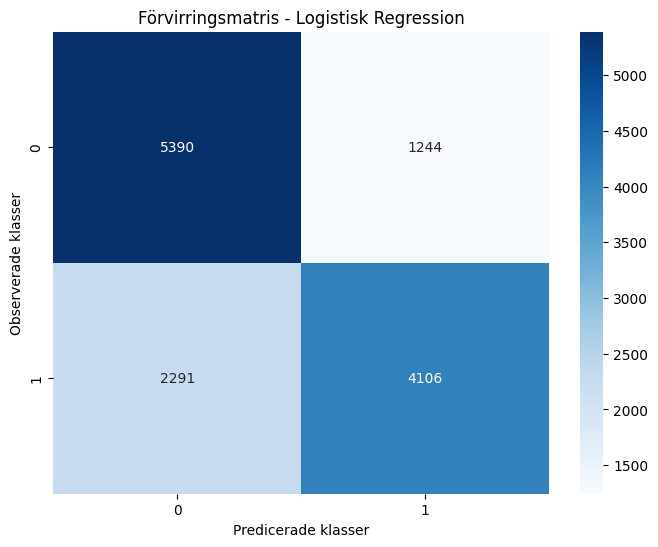

In [5]:
param_distribution = {
    'C': uniform(0.01, 10),
    'penalty': ['l2'],
    'solver': ['liblinear']
}

random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_distribution, n_iter=100, cv=5, scoring='accuracy', error_score='raise', random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

best_logreg = random_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_scaled)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = auc(*roc_curve(y_test, best_logreg.predict_proba(X_test_scaled)[:, 1])[:2])

print("Logistisk Regression")
print("Bästa hyperparametrar:", random_search.best_params_)
print("Noggrannhet på testdata:", logreg_accuracy)
print(classification_report(y_test, y_pred_logreg))

# Förvirringsmatris för logistisk regression
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicerade klasser')
plt.ylabel('Observerade klasser')
plt.title('Förvirringsmatris - Logistisk Regression')
plt.show()

Decision Tree
Bästa hyperparametrar: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Noggrannhet på testdata: 0.7226613460210268
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6634
           1       0.74      0.67      0.70      6397

    accuracy                           0.72     13031
   macro avg       0.72      0.72      0.72     13031
weighted avg       0.72      0.72      0.72     13031



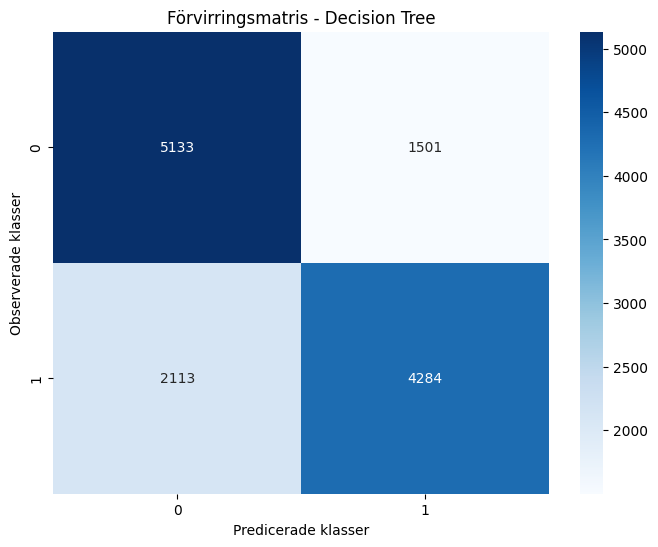

In [6]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', error_score='raise', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)

best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = auc(*roc_curve(y_test, best_dt.predict_proba(X_test_scaled)[:, 1])[:2])

print("Decision Tree")
print("Bästa hyperparametrar:", grid_search_dt.best_params_)
print("Noggrannhet på testdata:", dt_accuracy)
print(classification_report(y_test, y_pred_dt))

# Förvirringsmatris för Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicerade klasser')
plt.ylabel('Observerade klasser')
plt.title('Förvirringsmatris - Decision Tree')
plt.show()

Random Forest
Bästa hyperparametrar: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Noggrannhet på testdata: 0.7340956181413553
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6634
           1       0.76      0.66      0.71      6397

    accuracy                           0.73     13031
   macro avg       0.74      0.73      0.73     13031
weighted avg       0.74      0.73      0.73     13031



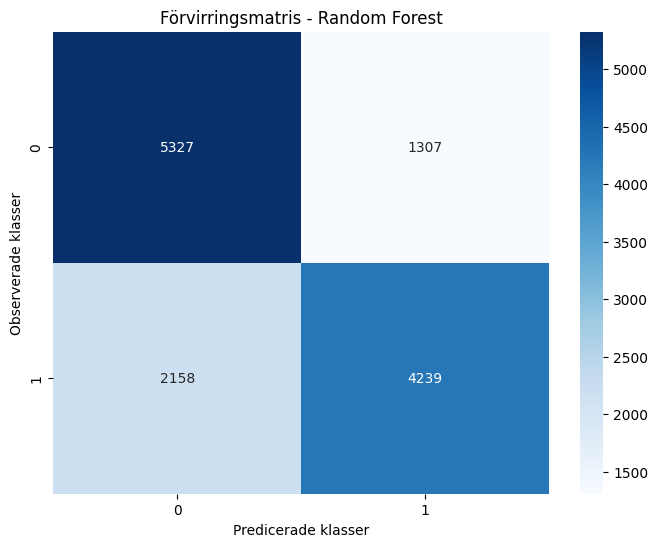

In [7]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],  # Ändrat från 'auto' till 'sqrt' och 'log2'
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', error_score='raise', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = auc(*roc_curve(y_test, best_rf.predict_proba(X_test_scaled)[:, 1])[:2])

print("Random Forest")
print("Bästa hyperparametrar:", grid_search_rf.best_params_)
print("Noggrannhet på testdata:", rf_accuracy)
print(classification_report(y_test, y_pred_rf))

# Förvirringsmatris för Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicerade klasser')
plt.ylabel('Observerade klasser')
plt.title('Förvirringsmatris - Random Forest')
plt.show()

Gradient Boosting Machine (GBM)
Bästa hyperparametrar: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Noggrannhet på testdata: 0.735323459442867
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6634
           1       0.75      0.69      0.72      6397

    accuracy                           0.74     13031
   macro avg       0.74      0.73      0.73     13031
weighted avg       0.74      0.74      0.73     13031



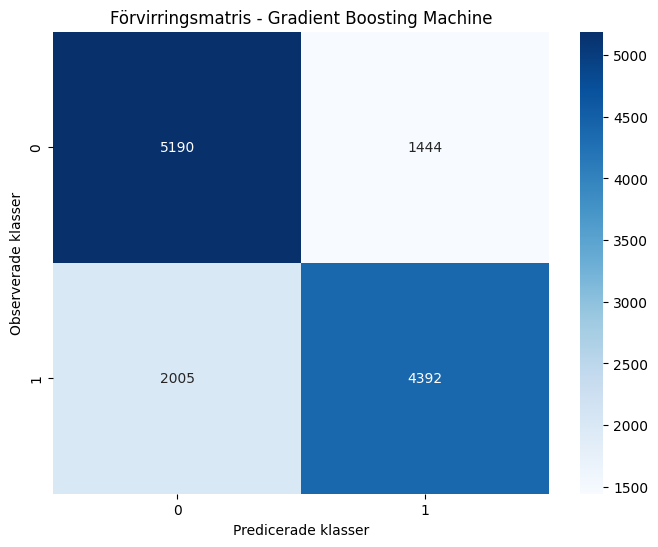

In [8]:
param_grid_gbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gbm = GridSearchCV(GradientBoostingClassifier(), param_grid_gbm, cv=5, scoring='accuracy', error_score='raise', n_jobs=-1)
grid_search_gbm.fit(X_train_scaled, y_train)

best_gbm = grid_search_gbm.best_estimator_
y_pred_gbm = best_gbm.predict(X_test_scaled)
gbm_accuracy = accuracy_score(y_test, y_pred_gbm)
roc_auc_gbm = auc(*roc_curve(y_test, best_gbm.predict_proba(X_test_scaled)[:, 1])[:2])

print("Gradient Boosting Machine (GBM)")
print("Bästa hyperparametrar:", grid_search_gbm.best_params_)
print("Noggrannhet på testdata:", gbm_accuracy)
print(classification_report(y_test, y_pred_gbm))

# Förvirringsmatris för GBM
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicerade klasser')
plt.ylabel('Observerade klasser')
plt.title('Förvirringsmatris - Gradient Boosting Machine')
plt.show()

Support Vector Machine (SVM)
Bästa hyperparametrar: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Noggrannhet på testdata: 0.7303353541554755
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      6634
           1       0.78      0.62      0.69      6397

    accuracy                           0.73     13031
   macro avg       0.74      0.73      0.73     13031
weighted avg       0.74      0.73      0.73     13031



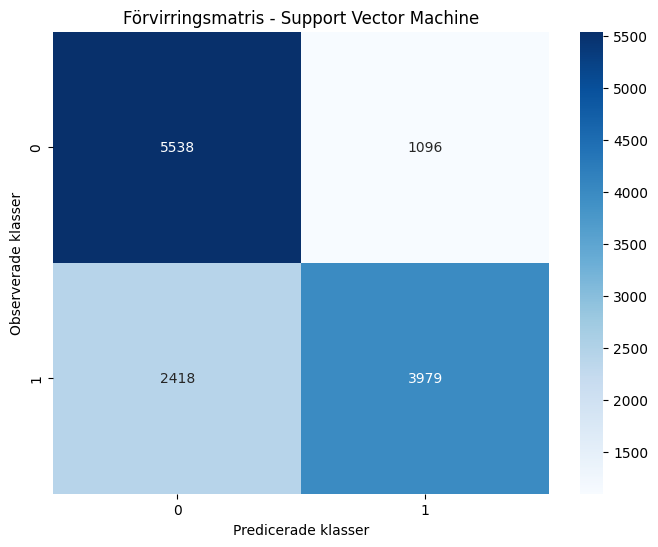

In [9]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', error_score='raise', n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = auc(*roc_curve(y_test, best_svm.predict_proba(X_test_scaled)[:, 1])[:2])

print("Support Vector Machine (SVM)")
print("Bästa hyperparametrar:", grid_search_svm.best_params_)
print("Noggrannhet på testdata:", svm_accuracy)
print(classification_report(y_test, y_pred_svm))

# Förvirringsmatris för SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicerade klasser')
plt.ylabel('Observerade klasser')
plt.title('Förvirringsmatris - Support Vector Machine')
plt.show()

In [10]:
# Skapar en sammanfattande tabell för modellernas prestanda
evaluation_results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM'],
    'Accuracy': [logreg_accuracy, dt_accuracy, rf_accuracy, gbm_accuracy, svm_accuracy],
    'ROC AUC': [roc_auc_logreg, roc_auc_dt, roc_auc_rf, roc_auc_gbm, roc_auc_svm]
}

evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)

                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.728724  0.791854
1        Decision Tree  0.722661  0.779084
2        Random Forest  0.734096  0.798137
3    Gradient Boosting  0.735323  0.799906
4                  SVM  0.730335  0.790084


In [12]:
# Väljer den bästa modellen baserat på noggrannhet
best_model = best_gbm

# Plockar ut 100 slumpmässiga rader från datamängden
test_samples = filtered_data.sample(n=100, random_state=42)
test_samples.to_csv('test_samples.csv', index=False)

# Tar bort dessa 100 rader från den ursprungliga datamängden och träna modellen på resterande data
data_for_training = filtered_data.drop(test_samples.index)
X_full_train = data_for_training.drop('cardio', axis=1)
y_full_train = data_for_training['cardio']

# Kontrollera och ersätt oändliga värden med NaN i hela träningsdatamängden
X_full_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Tar bort rader med NaN-värden
X_full_train.dropna(inplace=True)

# Synkroniserar y_full_train med X_full_train
y_full_train = y_full_train[X_full_train.index]

# Skalar om hela träningsdatamängden
scaler_full = StandardScaler()
X_full_train_scaled = scaler_full.fit_transform(X_full_train)

# Tränar modellen på hela träningsdatamängden
full_model = best_model
full_model.fit(X_full_train_scaled, y_full_train)

# Sparar modellen och scaler till .pkl-filer
joblib.dump(full_model, 'best_model.pkl', compress=True)
joblib.dump(scaler_full, 'scaler.pkl', compress=True)


['scaler.pkl']

In [14]:
# Laddar modellen och scalern från .pkl-filer
loaded_model = joblib.load('best_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Använder modellen för att göra prediktioner på nya data
new_data = test_samples.drop('cardio', axis=1)

# Kontrollerar och ersätt oändliga värden med NaN i nya data
new_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Tar bort rader med NaN-värden
new_data.dropna(inplace=True)

# Skalar nya data
new_data_scaled = loaded_scaler.transform(new_data)

# Gör prediktioner
predictions = loaded_model.predict(new_data_scaled)

print("Prediktioner för nya data:")
print(predictions)


Prediktioner för nya data:
[0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1
 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1]


# Resultat
Följande modeller presterade bäst baserat på noggrannhet och AUC:

**Gradient Boosting Machine (GBM)** presterade bäst med en noggrannhet på 73,5% och en AUC på 0.799.
**Random Forest** visade också stark prestanda med en noggrannhet på 73,4% och en AUC på 0.798.

### Diskussion och slutsats
Studien visar att maskininlärningsmodeller kan användas effektivt för att förutsäga hjärt-kärlsjukdomar baserat på klinisk och demografisk data. Gradient Boosting Machine (GBM) visade sig vara den mest effektiva modellen, vilket indikerar att komplexa, icke-linjära modeller kan fånga upp subtila mönster i data som enklare modeller missar.

### Begränsningar
Studien begränsas av kvaliteten på den ursprungliga datamängden, vilket kan påverka de slutliga resultaten. Trots omfattande datarensning kan vissa avvikelser kvarstå. Dessutom är modellen baserad på data från en specifik population, vilket kan begränsa dess generaliserbarhet till andra grupper.

### Framtida arbete
För framtida arbete rekommenderas att testa modellen på nya, oberoende dataset för att validera dess generaliserbarhet. Dessutom kan ytterligare funktioner och fler avancerade modeller utforskas för att ytterligare förbättra prediktionsförmågan.